In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/")

In [3]:
import torch
import numpy as np
import ml_collections
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from torch.utils.data import DataLoader
from diffusion_holder import DiffusionRunner
from transformers import BertConfig, BertTokenizerFast

from diffusion_holder import DiffusionRunner
from utils.util import set_seed, dict_to_cuda, mse_loss
from estimation_utils.util import estimate_model, reduce_metrics, gather_texts
import diffusion_utils.schedulers as schedulers

In [4]:
sns.set_theme()

# Self-condition

In [5]:
def create_config():
    config = ml_collections.ConfigDict()

    training = config.training = ml_collections.ConfigDict()
    training.training_iters = 500_000
    training.training_iters = training.training_iters
    training.checkpoint_freq = 50_000
    training.eval_freq = 5_000
    training.batch_size = 512  # * 8

    training.ode_sampling = False
    training.checkpoints_folder = '../checkpoints/'
    config.checkpoints_prefix = ''

    loss = config.loss = ml_collections.ConfigDict()
    loss.ce_coef = 0.

    refresh = config.refresh = ml_collections.ConfigDict()
    refresh.true = False
    refresh.prefix = "./checkpoints/wikipedia--t5-bert-self_cond_500000_.pth"
    refresh.wand_id = "g5fb4af3"

    validation = config.validation = ml_collections.ConfigDict()
    validation.batch_size = 256
    validation.validation_iters = int(10_000 / validation.batch_size)
    validation.num_gen_texts = 8192
    validation.p_uncond = 0.

    dynamic = config.dynamic = ml_collections.ConfigDict()
    dynamic.solver = 'euler'
    dynamic.scheduler = "sd"
    dynamic.N = 100
    dynamic.beta_min = 0.1
    dynamic.beta_max = 20
    dynamic.ode_sampling = False
    dynamic.coef_d = 10

    model = config.model = ml_collections.ConfigDict()
    model.ema_rate = 0.9999
    model.enc_type = "base"
    model.embeddings_type = "embeddings"
    model.dif_enc_type = "base"
    model.downstream_task = ""  # "qqp"
    model.dataset = "wikipedia"  # "glue"
    model.prediction = "x_0"
    model.loss = "L_x_0"
    model.decoder_path = "decoder-wikipedia-128.pth"

    data = config.data = ml_collections.ConfigDict()
    data.max_sequence_len = 64
    data.pos_begin = 0.0
    data.pos_end = 0.67
    data.enc_bert_mean = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-bert_base-wiki-mean.pt"
    data.enc_bert_std = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-bert_base-wiki-std.pt"

    data.enc_t5_mean = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-t5-wiki-mean.pth"
    data.enc_t5_std = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-t5-wiki-std.pth"

    config.finetuning = False
    config.seed = 0
    config.ddp = False
    config.bert_config = BertConfig.from_pretrained("bert-base-uncased")
    config.use_self_cond = True
    config.project_name = "test" #"dtg-exps-1.0"
    config.timesteps = "linear"

    return config

In [6]:
config = create_config()
config.checkpoints_prefix = "wikipedia--self_cond_time_shift_200000_"

diffusion = DiffusionRunner(config, latent_mode=config.model.embeddings_type, eval=True)

/home/vmeshchaninov/.conda/envs/fap2_env/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Some weights of the model checkpoint at t5-base were not used when initializing T5EncoderModel: ['decoder.block.6.layer.0.SelfAttention.q.weight', 'decoder.block.11.layer.0.SelfAttention.o.weight', 'decoder.block.1

Dataset tokenization (num_proc=30):   0%|          | 0/38661 [00:00<?, ? examples/s]

In [7]:
diffusion.set_valid_data_generator()

/home/vmeshchaninov/.conda/envs/fap2_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
loader = iter(diffusion.valid_loader)

In [21]:
X = next(loader)
X = dict_to_cuda(X)

with torch.no_grad():
    clean_X = diffusion.encoder_gen(**{"input_ids": X["input_ids"], "attention_mask": X["input_mask"]})
    cond_X = diffusion.encoder_cond(**{"input_ids": X["cond_ids"], "attention_mask": X["cond_mask"]})
    
cond_mask = X["cond_mask"]
attention_mask = None

In [22]:
eps_t = 1. / diffusion.dynamic.N
timesteps = torch.linspace(diffusion.dynamic.T, eps_t, diffusion.dynamic.N, device=diffusion.device)

In [ ]:
# No time shift

set_seed(0)
mask = None
batch_size = clean_X.shape[0]

with torch.no_grad():    
    losses_x_0_w_selfcond = []
    losses_x_0_wo_selfcond = []
    
    for t in tqdm(range(0, diffusion.dynamic.N)):
        vec_t = t * 1. / diffusion.dynamic.N * torch.ones(batch_size, device="cuda:0")
        set_seed(0)
        marg_forward = diffusion.dynamic.marginal(clean_X, vec_t)
        
        x_0_self_cond = torch.zeros_like(clean_X, dtype=clean_X.dtype)
        x_t = marg_forward['x_t']
        x_0 = diffusion.calc_score(
            model=diffusion.score_estimator, x_t=x_t, t=vec_t, cond=cond_X, attention_mask=None, cond_mask=X["cond_mask"],
            x_0_self_cond=x_0_self_cond
        )["x_0"]
        
        loss = mse_loss(x_0, clean_X, mask)
        losses_x_0_wo_selfcond.append(loss.item())
        
        x_0_self_cond = x_0
        x_0 = diffusion.calc_score(
            model=diffusion.score_estimator, x_t=x_t, t=vec_t, cond=cond_X, attention_mask=None, cond_mask=X["cond_mask"],
            x_0_self_cond=x_0_self_cond
        )["x_0"]
        loss = mse_loss(x_0, clean_X, mask)
        losses_x_0_w_selfcond.append(loss.item())

In [27]:
# time shift

set_seed(0)
mask = None
batch_size = clean_X.shape[0]

with torch.no_grad():    
    losses_x_0_w_selfcond = []
    losses_x_0_wo_selfcond = []
    
    for t in tqdm(range(0, diffusion.dynamic.N)):
        vec_t = t * 1. / diffusion.dynamic.N * torch.ones(batch_size, device="cuda:0")
        
        # wo_selfcond
        set_seed(0)
        x_0_self_cond = torch.zeros_like(clean_X, dtype=clean_X.dtype)
        marg_forward = diffusion.dynamic.marginal(clean_X, vec_t)
        x_t = marg_forward['x_t']
        x_0 = diffusion.calc_score(
            model=diffusion.score_estimator, x_t=x_t, t=vec_t, cond=cond_X, attention_mask=None, cond_mask=X["cond_mask"],
            x_0_self_cond=x_0_self_cond
        )["x_0"]
        
        loss = mse_loss(x_0, clean_X, mask)
        losses_x_0_wo_selfcond.append(loss.item())
        
        # w_selfcond
        set_seed(0)
        x_0_self_cond = torch.zeros_like(clean_X, dtype=clean_X.dtype)
        vec_t_next = torch.clip(vec_t + 1 / 200, max=diffusion.dynamic.T)
        marg_forward = diffusion.dynamic.marginal(clean_X, vec_t_next)
        x_t = marg_forward['x_t']
        x_0_self_cond = diffusion.calc_score(
            model=diffusion.score_estimator, x_t=x_t, t=vec_t_next, cond=cond_X, attention_mask=None, cond_mask=X["cond_mask"],
            x_0_self_cond=x_0_self_cond
        )["x_0"].detach()
        
        x_0 = diffusion.calc_score(
            model=diffusion.score_estimator, x_t=x_t, t=vec_t, cond=cond_X, attention_mask=None, cond_mask=X["cond_mask"],
            x_0_self_cond=x_0_self_cond
        )["x_0"]
        loss = mse_loss(x_0, clean_X, mask)
        losses_x_0_w_selfcond.append(loss.item())

100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


In [24]:
with open('tmp/trainsc-shifttime-w_selfcond.npy', 'wb') as f:
    np.save(f, np.array(losses_x_0_w_selfcond))

In [25]:
with open('tmp/trainsc-shifttime-wo_selfcond.npy', 'wb') as f:
    np.save(f, np.array(losses_x_0_wo_selfcond))

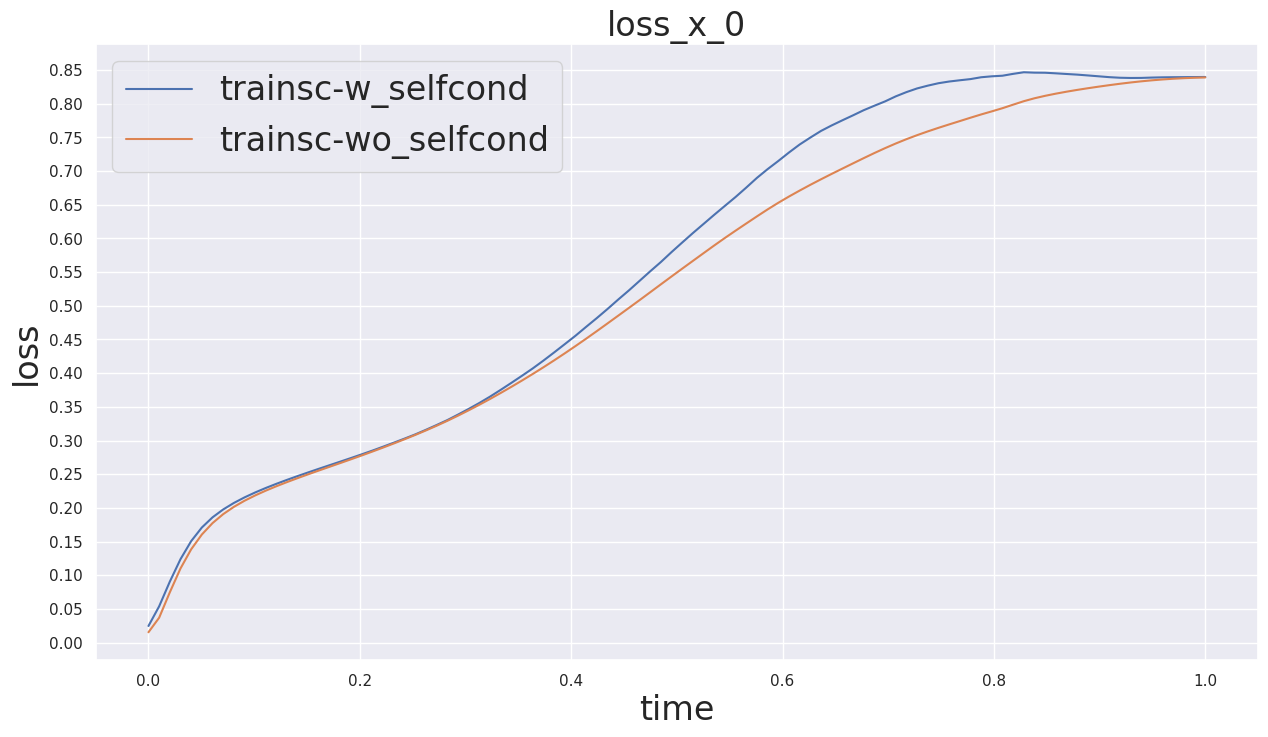

In [28]:
plt.figure(figsize=(15, 8))
plt.xlabel('time', fontsize=24)
plt.ylabel('loss', fontsize=24)
plt.title("loss_x_0", fontsize=24)
plt.yticks(np.arange(0, 1.01, 0.05))
timesteps = torch.linspace(0, 1, diffusion.dynamic.N)
plt.plot(timesteps, losses_x_0_w_selfcond, label="trainsc-w_selfcond")
plt.plot(timesteps, losses_x_0_wo_selfcond, label="trainsc-wo_selfcond")

plt.legend(fontsize=24)
plt.show()

### Test all dataloader

In [12]:
losses = []
eps = 1e-5

import random

with torch.no_grad():
    T = tqdm(diffusion.valid_loader)
    for X in T:
        X = dict_to_cuda(X)

        clean_x = diffusion.encoder_gen(**{"input_ids": X["input_ids"], "attention_mask": X["input_mask"]})
        cond = diffusion.encoder_cond(**{"input_ids": X["cond_ids"], "attention_mask": X["cond_mask"]})

        cond_mask = X["cond_mask"]
        batch_size = clean_x.shape[0]
        t = diffusion.sample_time(batch_size, eps=eps)

        # self-cond estimate
        x_0_self_cond = torch.zeros_like(clean_x, dtype=clean_x.dtype)
        if diffusion.use_self_cond and random.random() > 0.5:
            with torch.autocast(device_type='cuda'):
                t_next = torch.clip(t + 1 / 200, max=diffusion.dynamic.T)
                marg_forward = diffusion.dynamic.marginal(clean_x, t_next)
                x_t = marg_forward['x_t']
                with torch.no_grad():
                    x_0_self_cond = diffusion.ddp_score_estimator(
                        x_t=x_t, time_t=t_next, cond=cond,
                        attention_mask=None, cond_mask=X["cond_mask"],
                        x_0_self_cond=x_0_self_cond
                    ).detach()

        marg_forward = diffusion.dynamic.marginal(clean_x, t)
        x_t, noise, score_clean = marg_forward['x_t'], marg_forward['noise'], marg_forward['score']

        # model prediction
        with torch.autocast(device_type='cuda'):
            scores = diffusion.calc_score(
                model=diffusion.ddp_score_estimator,
                x_t=x_t,
                t=t,
                cond=cond,
                cond_mask=X["cond_mask"],
                attention_mask=None,
                x_0_self_cond=x_0_self_cond,
            )

        # MSE losses
        x_0, eps_theta, score = scores["x_0"], scores['eps_theta'], scores["score"]

        loss_x_0 = mse_loss(clean_x, x_0, None)
        losses.append(loss_x_0.item())
        T.set_description(f"{np.mean(losses):0.3f}")

0.505:   9%|▊         | 13/152 [00:13<01:36,  1.43it/s]Exception ignored in: <function tqdm.__del__ at 0x2b3acd277040>
Traceback (most recent call last):
  File "/home/vmeshchaninov/.conda/envs/fap2_env/lib/python3.9/site-packages/tqdm/std.py", line 1144, in __del__
    def __del__(self):
KeyboardInterrupt: 
0.505:   9%|▊         | 13/152 [00:14<02:32,  1.09s/it]


KeyboardInterrupt: 

# WO Self-condition

In [41]:
def create_config():
    config = ml_collections.ConfigDict()

    training = config.training = ml_collections.ConfigDict()
    training.training_iters = 500_000
    training.training_iters = training.training_iters
    training.checkpoint_freq = 50_000
    training.eval_freq = 5_000
    training.batch_size = 512  # * 8

    training.ode_sampling = False
    training.checkpoints_folder = '../checkpoints/'
    config.checkpoints_prefix = ''

    loss = config.loss = ml_collections.ConfigDict()
    loss.ce_coef = 0.

    refresh = config.refresh = ml_collections.ConfigDict()
    refresh.true = False
    refresh.prefix = "./checkpoints/wikipedia--t5-bert-self_cond_500000_.pth"
    refresh.wand_id = "g5fb4af3"

    validation = config.validation = ml_collections.ConfigDict()
    validation.batch_size = 256
    validation.validation_iters = int(10_000 / validation.batch_size)
    validation.num_gen_texts = 8192
    validation.p_uncond = 0.

    dynamic = config.dynamic = ml_collections.ConfigDict()
    dynamic.solver = 'euler'
    dynamic.scheduler = "sd"
    dynamic.N = 200
    dynamic.beta_min = 0.1
    dynamic.beta_max = 20
    dynamic.ode_sampling = False
    dynamic.coef_d = 10

    model = config.model = ml_collections.ConfigDict()
    model.ema_rate = 0.9999
    model.enc_type = "base"
    model.embeddings_type = "embeddings"
    model.dif_enc_type = "base"
    model.downstream_task = ""  # "qqp"
    model.dataset = "wikipedia"  # "glue"
    model.prediction = "x_0"
    model.loss = "L_x_0"
    model.decoder_path = "decoder-wikipedia-128.pth"

    data = config.data = ml_collections.ConfigDict()
    data.max_sequence_len = 64
    data.pos_begin = 0.0
    data.pos_end = 0.67
    data.enc_bert_mean = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-bert_base-wiki-mean.pt"
    data.enc_bert_std = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-bert_base-wiki-std.pt"

    data.enc_t5_mean = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-t5-wiki-mean.pth"
    data.enc_t5_std = "/home/vmeshchaninov/DiffusionTextGeneration-cond-ca/data/encodings-t5-wiki-std.pth"

    config.finetuning = False
    config.seed = 0
    config.ddp = False
    config.bert_config = BertConfig.from_pretrained("bert-base-uncased")
    config.use_self_cond = False
    config.project_name = "test" #"dtg-exps-1.0"
    config.timesteps = "linear"

    return config

In [42]:
config = create_config()
config.checkpoints_prefix = "wikipedia--t5-bert-initial_200000_"

diffusion = DiffusionRunner(config, latent_mode=config.model.embeddings_type, eval=True)

In [43]:
diffusion.set_valid_data_generator()

In [44]:
loader = iter(diffusion.valid_loader)

In [ ]:
X = next(loader)
X = dict_to_cuda(X)

with torch.no_grad():
    clean_X = diffusion.encoder_gen(**{"input_ids": X["input_ids"], "attention_mask": X["input_mask"]})
    cond_X = diffusion.encoder_cond(**{"input_ids": X["cond_ids"], "attention_mask": X["cond_mask"]})
    
cond_mask = X["cond_mask"]
attention_mask = None

In [ ]:
eps_t = 1. / diffusion.dynamic.N
timesteps = torch.linspace(diffusion.dynamic.T, eps_t, diffusion.dynamic.N, device=diffusion.device)

In [ ]:
mask = None
batch_size = clean_X.shape[0]

with torch.no_grad():    
    losses_x_0 = []
    
    for t in tqdm(range(0, diffusion.dynamic.N)):
        vec_t = t * 1. / diffusion.dynamic.N * torch.ones(batch_size, device="cuda:0")
        set_seed(0)
        marg_forward = diffusion.dynamic.marginal(clean_X, vec_t)
        
        x_t = marg_forward['x_t']
        x_0 = diffusion.calc_score(
            model=diffusion.score_estimator, x_t=x_t, t=vec_t, cond=cond_X, attention_mask=None, cond_mask=X["cond_mask"]
        )["x_0"]
        
        loss = mse_loss(x_0, clean_X, mask)
        losses_x_0.append(loss.item())

In [34]:
with open('tmp/train.npy', 'wb') as f:
    np.save(f, np.array(losses_x_0))

In [ ]:
plt.figure(figsize=(20, 8))
plt.xlabel('time', fontsize=24)
plt.ylabel('loss', fontsize=24)
plt.title("loss_x_0", fontsize=24)
plt.yticks(np.arange(0, 1.01, 0.05))
timesteps = torch.linspace(0, 1, diffusion.dynamic.N)
plt.plot(timesteps, np.load("tmp/train.npy"), label="default_train")
# plt.plot(timesteps, np.load("tmp/trainsc-wo_selfcond.npy"), label="sc_train, zero_self_cond")
# plt.plot(timesteps, np.load("tmp/trainsc-w_selfcond.npy"), label="sc_train, self_cond")

plt.plot(np.load('tmp/trainsc-shifttime-wo_selfcond.npy'), label="sc_train, zero_self_cond, shifttime")
plt.plot(np.load('tmp/trainsc-shifttime-w_selfcond.npy'), label="sc_train, self_cond, shifttime")

plt.legend(fontsize=24)
plt.show()

### Test all dataloader

In [47]:
losses = []

with torch.no_grad():
    T = tqdm(diffusion.valid_loader)
    for X in T:
        X = dict_to_cuda(X)

        clean_X = diffusion.encoder_gen(**{"input_ids": X["input_ids"], "attention_mask": X["input_mask"]})
        cond_X = diffusion.encoder_cond(**{"input_ids": X["cond_ids"], "attention_mask": X["cond_mask"]})

        cond_mask = X["cond_mask"]
        batch_size = clean_X.shape[0]
        time = diffusion.sample_time(batch_size)
        marg_forward = diffusion.dynamic.marginal(clean_X, time)
        x_t = marg_forward['x_t']
        x_0 = diffusion.calc_score(
            model=diffusion.score_estimator, x_t=x_t, t=time, cond=cond_X, attention_mask=None, cond_mask=X["cond_mask"]
        )["x_0"]
        loss = mse_loss(x_0, clean_X, None)
        losses.append(loss.item())
        T.set_description(f"{np.mean(losses):0.3f}")

0.534:  19%|█▉        | 29/152 [00:29<02:04,  1.01s/it]


KeyboardInterrupt: 

# Next chapter